In [1]:
import random

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import GAN
import importlib
importlib.reload(GAN) # For reloading after making changes
from GAN import *

%matplotlib inline

In [2]:
import pickle
# Save engineered dataset for use in analysis
# Save as pickle for faster reload

data = pickle.load(open('data/' + 'credicard.engineered.pkl','rb'))

In [40]:
train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1    492


In [39]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-0.246709,-0.118049,0.118209,-0.106173,0.282365,-0.037833,-0.107076,-0.205109,0.116520,-0.252140,...,0.070417,-0.004830,-0.074498,0.052869,0.008540,0.036879,0.064699,-0.043406,-0.190275,1
623,-0.246395,-0.155386,-0.191201,0.071786,0.161643,0.098519,-0.079926,0.026318,-0.005676,-0.024663,...,0.090085,0.060008,0.220345,-0.048511,0.053675,-0.030144,-0.062625,0.010835,0.188374,1
4920,-0.227440,-0.117596,0.106537,-0.023726,0.164581,-0.059528,-0.005689,0.045455,-0.033420,-0.021686,...,-0.040049,-0.128482,0.027660,-0.014419,-0.029948,-0.112526,0.009802,-0.046361,0.140786,1
6108,-0.215449,-0.224536,0.082260,-0.171003,0.189268,-0.081734,-0.128093,-0.282614,-0.020830,-0.022552,...,0.078088,0.024386,-0.069854,-0.008834,0.048421,-0.136344,-0.204923,0.257382,0.056871,1
6329,-0.212917,0.063013,0.182870,-0.283897,0.334269,0.262577,-0.101912,0.138506,-0.041559,-0.116769,...,-0.051607,-0.097035,-0.105180,-0.269572,0.285626,0.117538,-0.002482,0.044472,-0.148435,1
6331,-0.212883,0.000430,0.250580,-0.411587,0.471495,0.055665,-0.251680,-0.131901,0.012945,-0.254489,...,0.049626,-0.083789,-0.086399,0.021290,0.285545,0.105337,0.182300,0.155589,-0.148435,1
6334,-0.212841,0.001367,0.250254,-0.432685,0.448387,0.096336,-0.188662,-0.136538,0.025391,-0.285757,...,0.050442,-0.079475,-0.107230,-0.125471,0.307908,0.112121,0.182602,0.150477,-0.148435,1
6336,-0.212803,0.016827,0.224846,-0.380935,0.429297,0.120802,-0.181658,-0.065710,0.011142,-0.201552,...,0.021322,-0.089906,-0.088328,-0.118307,0.271586,0.115146,0.131434,0.122537,-0.148435,1
6338,-0.212765,0.016157,0.230671,-0.370331,0.427120,0.112591,-0.199010,-0.060350,0.004654,-0.243820,...,0.028430,-0.070518,-0.093491,-0.036299,0.282911,0.101859,0.128550,0.121948,-0.148435,1
6427,-0.212484,0.037047,0.139338,-0.351523,0.283055,-0.125370,-0.130018,-0.320800,0.089063,-0.044246,...,0.080279,0.015095,0.096251,-0.060217,-0.353570,0.072976,0.147300,0.030105,-0.148435,1


In [54]:
class TabularDataset(Dataset):

    def __init__(self, train_no_label): 
        'Initialization'
        self.train_no_label = train_no_label



    def __len__(self):
        return len(self.train_no_label)

    def __getitem__(self, index):
        train_no_label = self.train_no_label.iloc[index, 0:].values
        return train_no_label



In [55]:
dataset = TabularDataset(train_no_label)

In [56]:
dataset

In [57]:


# Mini-batch size
mb_size = 128

train_loader = DataLoader(dataset=dataset,
                            batch_size = mb_size,
                            shuffle = False)


In [58]:
rand_dim = 32 # 32 # needs to be ~data_dim


nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 1e-3 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
# train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
# train_no_label = train[ data_cols ]

In [59]:
data_dim = len(data_cols)
base_n_count = 128 # 128
xgb_losses = []

In [60]:
def init_weight(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [61]:
# cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(rand_dim, base_n_count),
            nn.LeakyReLU(alpha=0.2),
            nn.Linear(base_n_count, base_n_count*2),
            nn.LeakyReLU(alpha=0.2),
            nn.Linear(base_n_count*2, base_n_count*4),
            nn.LeakyReLU(alpha=0.2),
            nn.Linear(base_n_count*4, data_dim),
        )
        self.model.apply(init_weight)

    def forward(self, x):
        return self.model(x)
        
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, base_n_count*4),
            nn.LeakyReLU(alpha=0.2),
            nn.Linear(base_n_count*4, base_n_count*2),
            nn.LeakyReLU(alpha=0.2),
            nn.Linear(base_n_count*2, base_n_count),
            nn.LeakyReLU(alpha=0.2),
            nn.Linear(base_n_count, 1),
            nn.Sigmoid(alpha=0.2)
        )
        self.model.apply(init_weight)
        
    def forward(self, x):
        return self.model(x)
    
generator = Generator()
discriminator = Discriminator()

G_solver = optim.Adam(generator.parameters(), lr = learning_rate)
D_solver = optim.Adam(discriminator.parameters(), lr = learning_rate)  
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator


# if cuda:
#     generator.cuda()
#     discriminator.cuda()
#     adversarial_loss.cuda()

In [62]:
label_cols = []
gan_fraud_loss = []

In [63]:
train_loader

In [64]:
date.type()

'torch.DoubleTensor'

In [65]:
for i, date in enumerate(train_loader):
    i, x = i, date
    print(i, date)
    

0 tensor([[-2.4671, -1.1805,  1.1821,  ...,  0.6470, -0.4341, -1.9028],
        [-2.4639, -1.5539, -1.9120,  ..., -0.6262,  0.1083,  1.8837],
        [-2.2744, -1.1760,  1.0654,  ...,  0.0980, -0.4636,  1.4079],
        ...,
        [-0.5250, -6.5532,  3.9815,  ..., -2.0258, -1.5785,  0.2981],
        [-0.5241, -6.6274,  4.0698,  ..., -2.9376, -2.2642,  0.5755],
        [-0.5239, -6.9846,  4.2332,  ..., -3.4851, -2.0105, -1.5615]],
       dtype=torch.float64)
1 tensor([[-5.2370e-01, -7.0951e+00,  3.8420e+00,  ..., -3.7385e+00,
         -2.0808e+00, -4.5586e-01],
        [-5.2180e-01, -7.6689e+00,  4.8902e+00,  ..., -3.2477e+00,
         -2.1431e+00,  2.4543e-01],
        [-5.1971e-01, -7.6430e+00,  5.0877e+00,  ..., -4.0170e+00,
         -3.3471e+00,  1.4855e+00],
        ...,
        [ 1.1654e+00,  5.5270e-01,  6.6303e-01,  ...,  2.2085e-01,
          3.4033e-01, -1.4843e+00],
        [ 1.1658e+00, -6.6287e-01,  6.5383e-01,  ...,  2.5978e-04,
          4.1110e-01, -1.4843e+00],
      

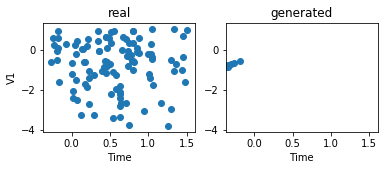

Epoch:0,   G_loss:6.6953171491622925,   D_loss:0.28389012068510056


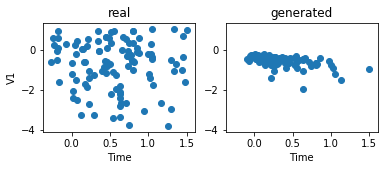

Epoch:50,   G_loss:6.139258146286011,   D_loss:1.2162827253341675


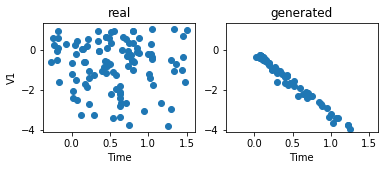

Epoch:100,   G_loss:7.124495625495911,   D_loss:2.315250501036644


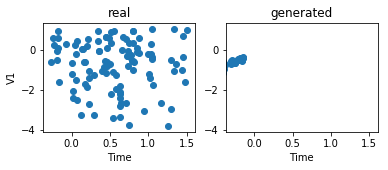

Epoch:150,   G_loss:3.7686519026756287,   D_loss:0.18394812941551208


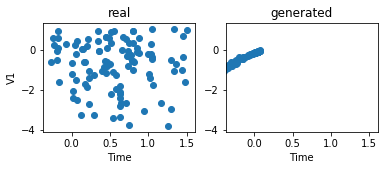

Epoch:200,   G_loss:1.7092114984989166,   D_loss:0.852738544344902


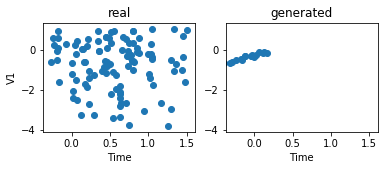

Epoch:250,   G_loss:9.208434820175171,   D_loss:0.24986688420176506


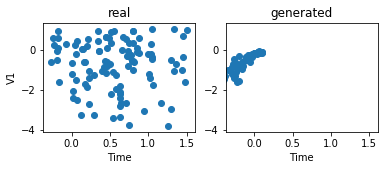

Epoch:300,   G_loss:2.3084120750427246,   D_loss:1.1248004883527756


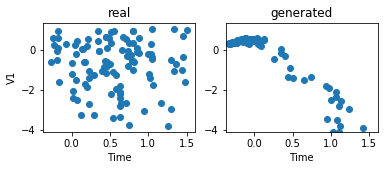

Epoch:350,   G_loss:9.659287452697754,   D_loss:0.5534423366189003


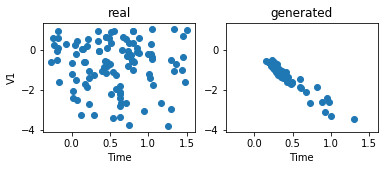

Epoch:400,   G_loss:1.6232401579618454,   D_loss:1.425955668091774


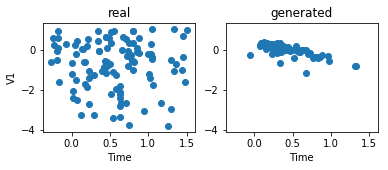

Epoch:450,   G_loss:2.581279158592224,   D_loss:0.7632491886615753


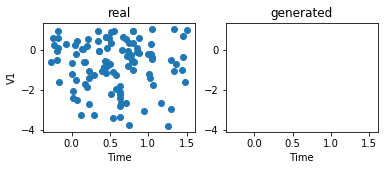

Epoch:500,   G_loss:4.258026838302612,   D_loss:1.0197346359491348


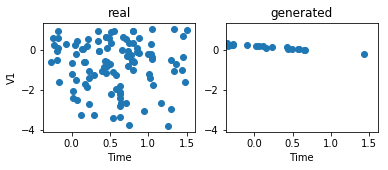

Epoch:550,   G_loss:3.415542244911194,   D_loss:1.4650825560092926


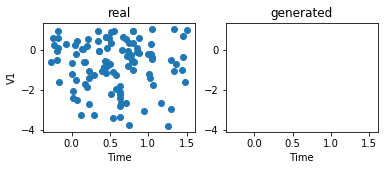

Epoch:600,   G_loss:4.451361894607544,   D_loss:3.5515215396881104


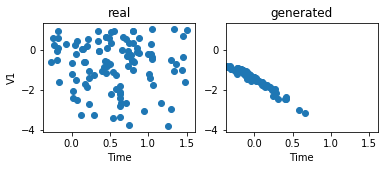

Epoch:650,   G_loss:2.3411816358566284,   D_loss:0.3357371427118778


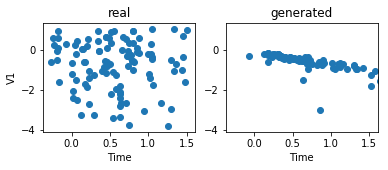

Epoch:700,   G_loss:2.7763686776161194,   D_loss:1.0227122157812119


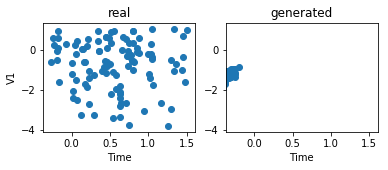

Epoch:750,   G_loss:1.2924270331859589,   D_loss:0.9000261425971985


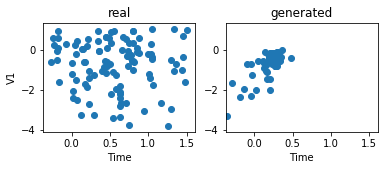

Epoch:800,   G_loss:1.7207358181476593,   D_loss:0.7871123999357224


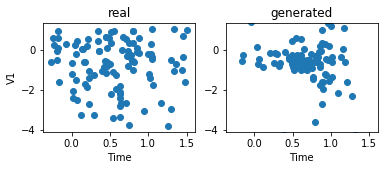

Epoch:850,   G_loss:2.547220528125763,   D_loss:0.662568561732769


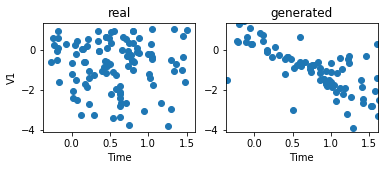

Epoch:900,   G_loss:3.094117283821106,   D_loss:0.9435602724552155


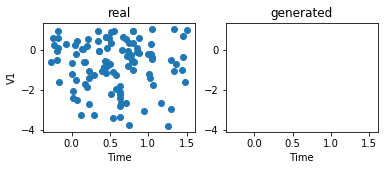

Epoch:950,   G_loss:1.9448646008968353,   D_loss:0.7911879569292068


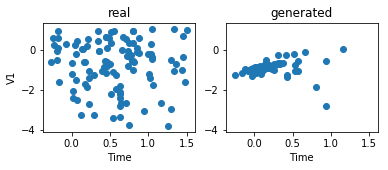

Epoch:1000,   G_loss:1.964048594236374,   D_loss:0.4366920292377472


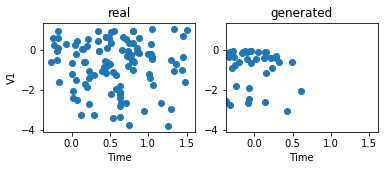

Epoch:1050,   G_loss:2.571587085723877,   D_loss:1.2132993638515472


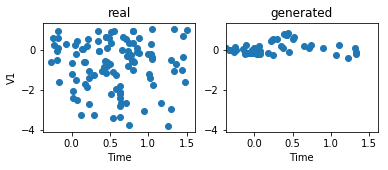

Epoch:1100,   G_loss:2.7305872440338135,   D_loss:0.6880383193492889


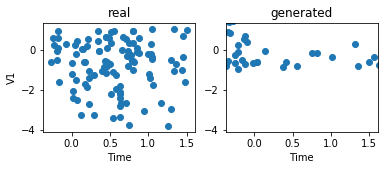

Epoch:1150,   G_loss:3.2744542360305786,   D_loss:0.374006949365139


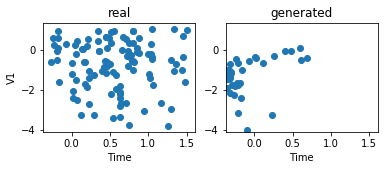

Epoch:1200,   G_loss:2.5895058512687683,   D_loss:0.4444337338209152


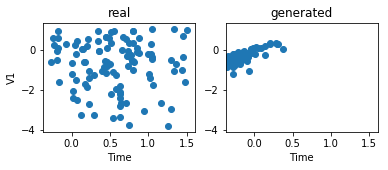

Epoch:1250,   G_loss:2.171175330877304,   D_loss:0.7821981757879257


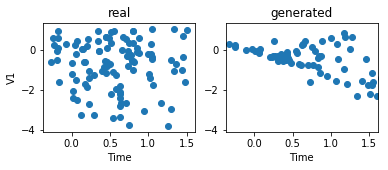

Epoch:1300,   G_loss:2.38988995552063,   D_loss:0.7053357660770416


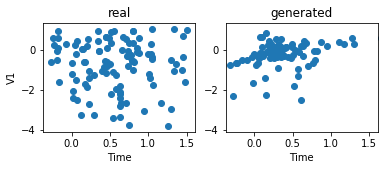

Epoch:1350,   G_loss:2.6325339674949646,   D_loss:1.1598564833402634


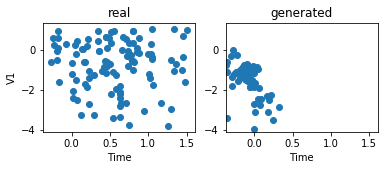

Epoch:1400,   G_loss:2.7828555703163147,   D_loss:0.4602082371711731


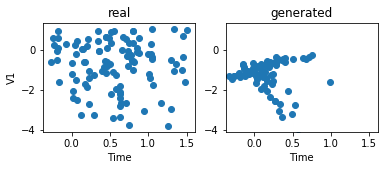

Epoch:1450,   G_loss:1.7836213111877441,   D_loss:0.5184087306261063


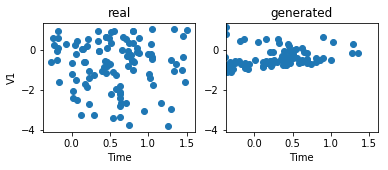

Epoch:1500,   G_loss:2.7071220874786377,   D_loss:1.0220618098974228


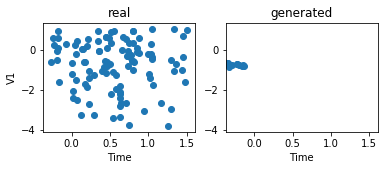

Epoch:1550,   G_loss:2.2491626143455505,   D_loss:1.784384697675705


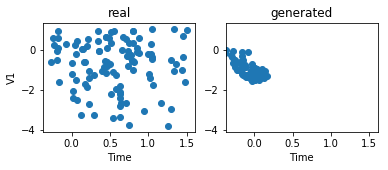

Epoch:1600,   G_loss:1.521393060684204,   D_loss:0.735375851392746


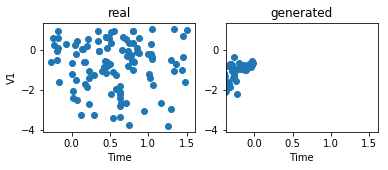

Epoch:1650,   G_loss:2.7344606518745422,   D_loss:0.3520929738879204


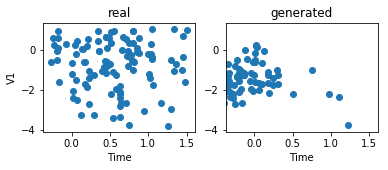

Epoch:1700,   G_loss:2.6422659158706665,   D_loss:0.5194310918450356


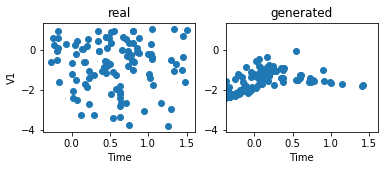

Epoch:1750,   G_loss:1.9578136205673218,   D_loss:0.3880405128002167


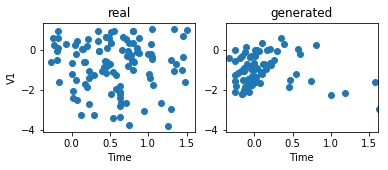

Epoch:1800,   G_loss:1.4834884405136108,   D_loss:0.7281231582164764


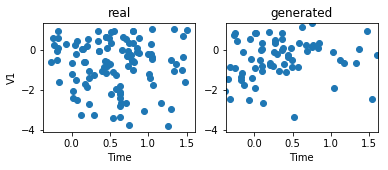

Epoch:1850,   G_loss:2.0842005908489227,   D_loss:0.6988936066627502


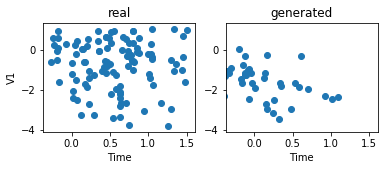

Epoch:1900,   G_loss:3.785223662853241,   D_loss:1.8673082888126373


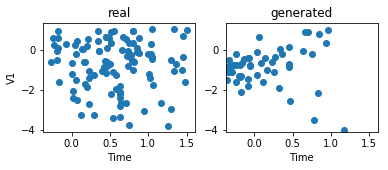

Epoch:1950,   G_loss:1.8729524612426758,   D_loss:0.608147993683815


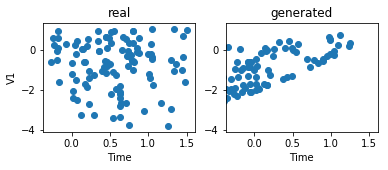

Epoch:2000,   G_loss:1.8213197886943817,   D_loss:0.5472540333867073


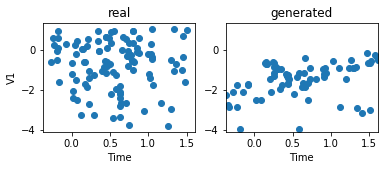

Epoch:2050,   G_loss:2.701608896255493,   D_loss:0.6014942526817322


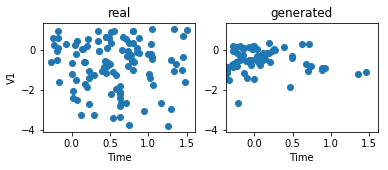

Epoch:2100,   G_loss:1.6819049715995789,   D_loss:1.0199776589870453


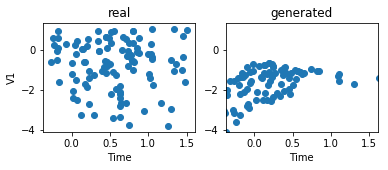

Epoch:2150,   G_loss:2.7033063769340515,   D_loss:0.3472994565963745


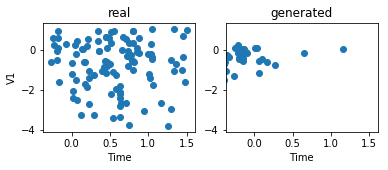

Epoch:2200,   G_loss:1.7248506546020508,   D_loss:0.6906396001577377


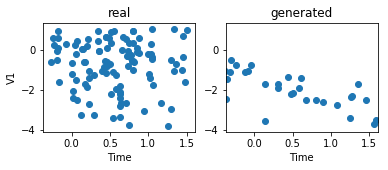

Epoch:2250,   G_loss:1.9256797134876251,   D_loss:1.1480982303619385


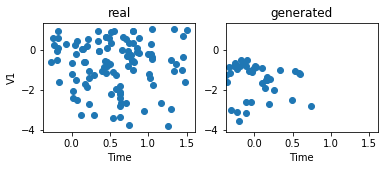

Epoch:2300,   G_loss:2.064367413520813,   D_loss:1.090758591890335


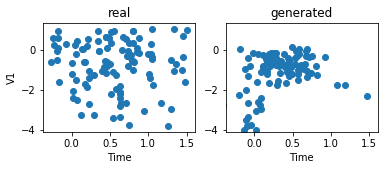

Epoch:2350,   G_loss:1.9192107021808624,   D_loss:0.4297044277191162


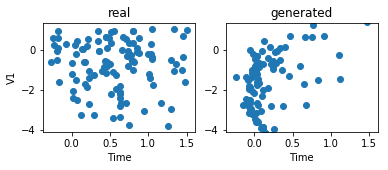

Epoch:2400,   G_loss:2.311106860637665,   D_loss:0.6920820400118828


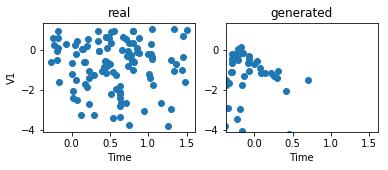

Epoch:2450,   G_loss:2.1466533839702606,   D_loss:1.157568320631981


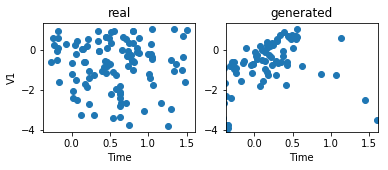

Epoch:2500,   G_loss:1.7330325543880463,   D_loss:0.7235434353351593


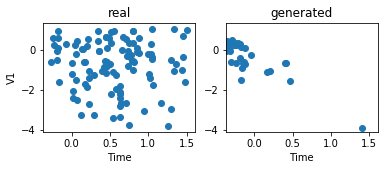

Epoch:2550,   G_loss:2.130614995956421,   D_loss:0.6532682627439499


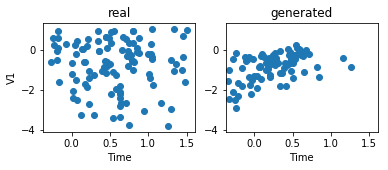

Epoch:2600,   G_loss:2.066008150577545,   D_loss:0.5928226932883263


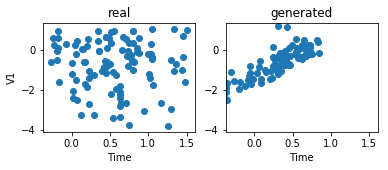

Epoch:2650,   G_loss:1.6530399024486542,   D_loss:0.748411625623703


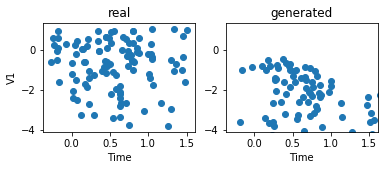

Epoch:2700,   G_loss:3.9381962418556213,   D_loss:0.9824000895023346


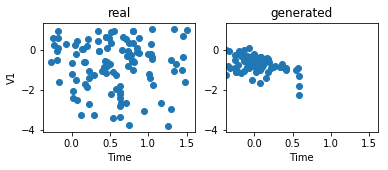

Epoch:2750,   G_loss:2.0261785686016083,   D_loss:0.37751686573028564


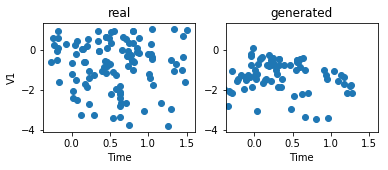

Epoch:2800,   G_loss:1.4130909442901611,   D_loss:0.7318829447031021


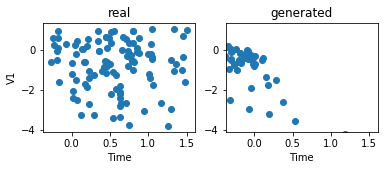

Epoch:2850,   G_loss:1.6392965912818909,   D_loss:0.8384808301925659


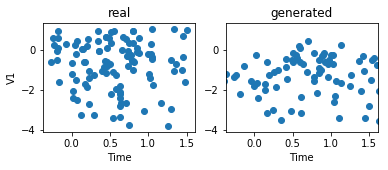

Epoch:2900,   G_loss:2.208755761384964,   D_loss:1.0639063119888306


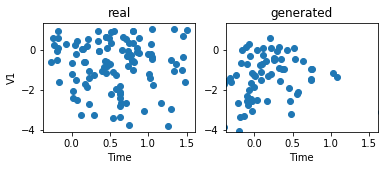

Epoch:2950,   G_loss:4.244406461715698,   D_loss:1.9389615654945374


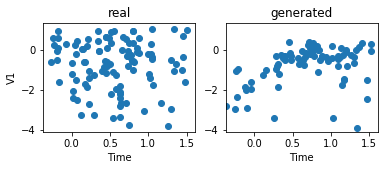

Epoch:3000,   G_loss:3.1779434084892273,   D_loss:0.570321649312973


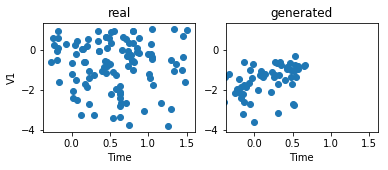

Epoch:3050,   G_loss:3.36456435918808,   D_loss:1.6191444993019104


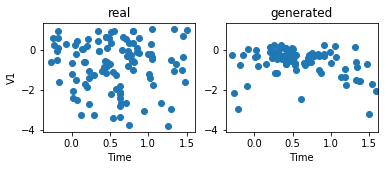

Epoch:3100,   G_loss:1.5186463594436646,   D_loss:1.172016903758049


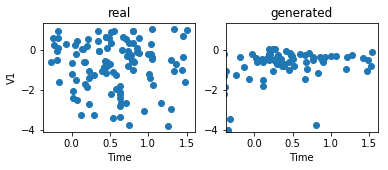

Epoch:3150,   G_loss:1.8637166619300842,   D_loss:1.0281478464603424


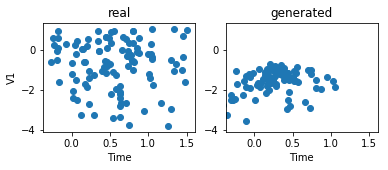

Epoch:3200,   G_loss:2.560043454170227,   D_loss:0.6066053360700607


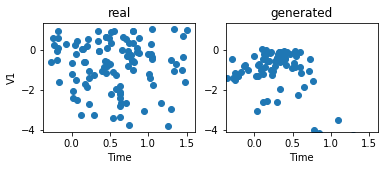

Epoch:3250,   G_loss:4.001059591770172,   D_loss:1.348375141620636


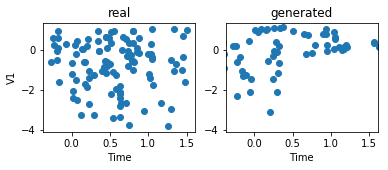

Epoch:3300,   G_loss:3.398213505744934,   D_loss:0.788427047431469


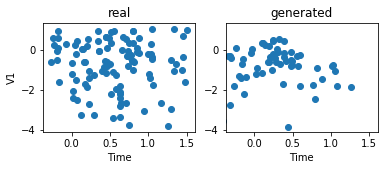

Epoch:3350,   G_loss:1.4634090065956116,   D_loss:0.8126918226480484


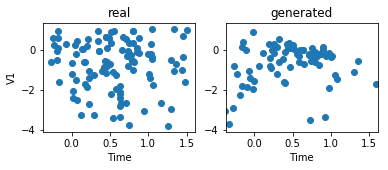

Epoch:3400,   G_loss:2.3021129965782166,   D_loss:0.6151744574308395


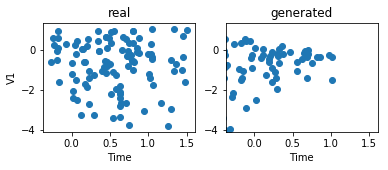

Epoch:3450,   G_loss:3.093054950237274,   D_loss:0.36274275183677673


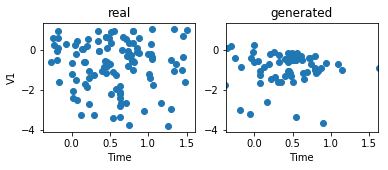

Epoch:3500,   G_loss:2.2929766178131104,   D_loss:0.7498519718647003


KeyboardInterrupt: 

In [67]:
for epoch in range(5000+1):
    G_loss_run = 0.0
    D_loss_run = 0.0
#     for i, data in enumerate(train_loader):
#         x, _ = data
    for i, date in enumerate(train_loader):
        x = torch.DoubleTensor(date).float()
        mb_size = x.size(0)

        # Definig labels for real (1s) and fake (0s) images
#         one_labels = torch.ones(mb_size, 1)
        one_labels = torch.tensor(np.random.uniform(low=0.999, high=1.0, size=mb_size), dtype=torch.float)
        
#         zero_labels = torch.zeros(mb_size, 1)
        zero_labels = torch.tensor(np.random.uniform(low=0.0, high=0.001, size=mb_size), dtype=torch.float)
        
        # Random normal distribution for each image
        z = torch.randn(mb_size, rand_dim)
        
        # Feed forward in discriminator both 
        # fake and real images
        G_sample = generator(z)
        D_real = discriminator(x)
        D_fake = discriminator(generator(z))
        
        
        
        # Defining the loss for Discriminator
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_fake_loss + D_real_loss
        D_loss_numpy = D_loss.detach().numpy()
        
        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = torch.randn(mb_size, rand_dim)
        D_fake = discriminator(generator(z))
        
        # loss function of generator
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        G_loss_numpy = G_loss.detach().numpy()
        
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        G_loss_run += G_loss.item()
        gan_fraud_loss.append((D_loss_numpy, G_loss_numpy))
        D_loss_run += D_loss.item()
        
           
        
    if not epoch % 50:
        xgb_loss = CheckAccuracy( x.detach().numpy() , G_sample.detach().numpy() , data_cols, label_cols, seed=0, with_class=False, data_dim=data_dim )
        xgb_losses = np.append(xgb_losses, xgb_loss)
        PlotData(x.detach().numpy() , G_sample.detach().numpy(), data_cols, label_cols, seed=0, with_class=False, data_dim=2, save=False, prefix='')
        print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
#         samples = generator(z).detach()
    # printing loss after each epoch 
    

In [ ]:
gan_fraud_loss

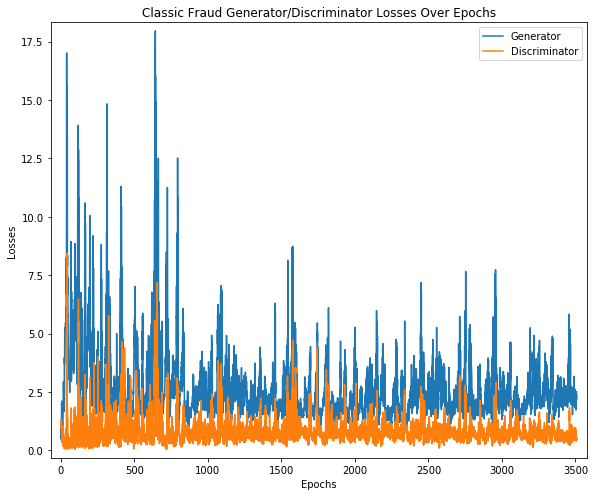

In [69]:
# Plot loss results
epoch_axis = np.linspace(1, epoch, num=14306)

# Extract generator and discriminator losses from 'gan_fraud' object
gen_losses_fraud = [gen[1] for gen in gan_fraud_loss]
disc_losses_fraud = [disc[0] for disc in gan_fraud_loss]

# Plot discriminator/generator losses of fraud/fraudless beside each other
_ = plt.figure(figsize=(16,7))

_ = plt.subplot(1, 2, 2)
_ = plt.plot(epoch_axis, gen_losses_fraud, label='Generator')
_ = plt.plot(epoch_axis, disc_losses_fraud, label='Discriminator')
_ = plt.xlabel('Epochs'); _ = plt.ylabel('Losses')
_ = plt.legend(loc='best'); _ = plt.title('Classic Fraud Generator/Discriminator Losses Over Epochs')
_ = plt.tight_layout(); plt.margins(0.02)

plt.show()

In [ ]:
seed = 42
random.seed(42)
credit_csv_dir = 'creditcard.csv'
credit = pd.read_csv(credit_csv_dir)
credit_X = credit.drop(labels=['Time','Class'], axis='columns')
credit_Y = credit['Class'].values
X_Train, X_Test, y_train, y_test = train_test_split(credit_X, credit_Y, test_size=0.25, 
                                                    random_state=seed)
print(credit.info(null_counts=True))
print(credit.describe(include='all'))
print(credit['Class'].value_counts())
credit.head()

In [ ]:
X_amt_tr, X_amt_te, y_amt_tr, y_amt_te = train_test_split(
    credit.drop(columns=['Class']).values, credit['Class'].values,
    test_size=0.25, random_state=42)

In [ ]:
amt_tr = np.concatenate((X_amt_tr, y_amt_tr.reshape(-1, 1)), axis=1)
amt_tr_df = pd.DataFrame(amt_tr, columns=credit.columns)
amt_te = np.concatenate((X_amt_te, y_amt_te.reshape(-1, 1)), axis=1)
amt_te_df = pd.DataFrame(amt_te, columns=credit.columns)

In [ ]:
tl_tr_fraud_amt = amt_tr_df[amt_tr_df['Class'] == 1]['Amount'].sum()
print('{}$'.format(tl_tr_fraud_amt))
tl_te_fraud_amt = amt_te_df[amt_te_df['Class'] == 1]['Amount'].sum()
print('{}$'.format(tl_te_fraud_amt))

In [ ]:
# Labels
X_cols = list(credit.drop(labels=['Time', 'Class'], axis='columns').columns)
y_cols = credit[['Class']].columns
target_names = credit['Class'].map(lambda x: 'Non-Fraud' if x==0 else 'Fraud').unique()

In [ ]:
# Training data as dataframe

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train_df = pd.DataFrame(X_Train, columns=X_cols)
X_train_df['Amount'] = StandardScaler().fit_transform(
    X_train_df['Amount'].values.reshape(-1, 1))
X_train_df = X_train_df.reset_index().drop(columns=['index'])

In [ ]:
y_train_df = pd.DataFrame(y_train, columns=y_cols)
# Full dataframe
train_df = pd.concat([X_train_df, y_train_df], join='outer', axis='columns')

In [ ]:
# X, y as numpy array
X_train, y_train = X_train_df.values, y_train_df.values

In [ ]:
# Test data as dataframe
X_test_df = pd.DataFrame(X_Test, columns=X_cols)
X_test_df['Amount'] = StandardScaler().fit(
    X_train_df['Amount'].values.reshape(-1, 1)).transform(X_test_df['Amount'].values.reshape(-1, 1))
X_test_df = X_test_df.reset_index().drop(columns=['index'])
y_test_df = pd.DataFrame(y_test, columns=y_cols)
# Full dataframe
test_df = pd.concat([X_test_df, y_test_df], join='outer', axis='columns')
# X, y as numpy array
X_test, y_test = X_test_df.values, y_test_df.values

In [ ]:
# Check number of frauds in both training and testing data
print('Number of frauds in training data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_train), y_train.shape[0], np.mean(y_train)*100))
print('Number of frauds in test data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_test), y_test.shape[0], np.mean(y_test)*100))

In [ ]:
import copy

In [ ]:
# 2-component PCA plot
    # PCA is sensitive to dimensional scales, thus the need to standardise matrix X
X_pca = copy.deepcopy(X_train)
y_pca = copy.deepcopy(y_train).reshape(-1,)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2, random_state=seed)
X_r = pca.fit_transform(X_pca)

In [ ]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(6,5)); colors = ['brown', 'cyan']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.6, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud/Non-Fraud')
plt.tight_layout(); plt.margins(0.02)

In [ ]:
# Kernel Density Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,18))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(5, 6, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=0.7, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

In [ ]:

# Histogram Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,18))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(5, 6, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='hist', bins=100, alpha=0.7, 
                                           legend='best', density=True)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

In [ ]:
import scipy.stats as stats

In [ ]:
# Perform Wilcoxon Rank-Sum Test at 5% Level to determine feature relevance

# Keep results if needed later
wilcox_result = dict([])

for feat in X_cols:   
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    
    # Draw 300 samples (only 379 fraud data in training set, attempt to draw close to the hilt)
    random.seed(42)
    fraud_wilcox = random.sample(list(temp_df[temp_df['Class']==1][feat]), k=300)
    nonfraud_wilcox = random.sample(list(temp_df[temp_df['Class']==0][feat]), k=300)
    
    rank_sums, p_val_wilcox = stats.wilcoxon(fraud_wilcox, nonfraud_wilcox)
    
    if p_val_wilcox > 0.05:
        wilcox_result[feat] = ('No_Diff', p_val_wilcox)
        print('Feature "{}" failed to be rejected at 5% level with p-value {:.10f}'.format(feat, p_val_wilcox))
    else:
        wilcox_result[feat] = ('Diff', p_val_wilcox)
    
# Rank-Sum Test determined differences in classes within feature
wilcox_feat = [feat for feat in wilcox_result.keys() if wilcox_result[feat][0] == 'Diff']
print('\n', 'Wilcoxon Rank-Sum Relevant Features: ', wilcox_feat)
print('Total number of features selected: {}'.format(len(wilcox_feat)))

In [ ]:
unselected_feats = list(set(X_cols).difference(wilcox_feat))
print('Unselected features: {}'.format(unselected_feats))

In [ ]:
# Obtain the top 6 most correlated wilcoxon-selected variables' to observe their scatter pair plot relations

# Check for high correlations
wilcox_corr = X_train_df.drop(columns=['V15', 'Amount', 'V13', 'V26', 'V22', 'V23']).corr().abs()
wilcox_corr_pdSr = wilcox_corr.unstack()
wilcox_corr_pdSr_sort = wilcox_corr_pdSr.sort_values(ascending=False).to_frame()

# Top 6 correlated variable pairs
wilcox_corr_pdSr_sort.iloc[23:35:2, :].rename(index=str, columns={0:'pearson_rho'})

In [ ]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(11, 7))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(2, 3, (plot+1))
    
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], 
                    group[1][corr_top6[plot][1]], 
                    c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0]); plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

In [ ]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [ ]:
# Using default values except "penalty='elasticnet'"
# To preserve/remove meaningful/irrelevant features without absolute purging
sgd_clf = SGDClassifier(penalty='elasticnet', 
                        random_state=seed, class_weight='balanced')

# Measure Start Time
start_time = time.time()

# Fit and obtain predictions
sgd_clf.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_train)
y_hat = sgd_clf.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

pred_score = sgd_clf.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_test)
print('Prediction Score: ', pred_score, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat))

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Measuring time taken for grid searching the optimal parameters
sgd_params = {'loss':['hinge', 'log', 'modified_huber', 'perceptron'],
              'penalty':['l1', 'l2', 'elasticnet'],
              'alpha':np.logspace(0.0001, 5, 5),
              'l1_ratio':list(np.linspace(0.0001, 1.0, 20))+[0.15],
              'random_state':[42], 
              'n_jobs':[-1],
              'eta0':[0.0001],
              'class_weight':['balanced']}
sgd_gridsearch = GridSearchCV(SGDClassifier(), sgd_params, cv=5, verbose=1, n_jobs=-1)

# Measure Start Time
start_time = time.time()
sgd_gridsearch.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_hat_grid = sgd_gridsearch.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values)
pred_score_grid = sgd_gridsearch.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_test)
print('Prediction Score: ', pred_score_grid, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat_grid), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat_grid))

In [ ]:
# Print best parameters used in 'GridSearchCV'
print(sgd_gridsearch.best_params_)

In [ ]:
from imblearn import pipeline
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Classifier
sgd_clf = SGDClassifier(penalty='elasticnet', random_state=42, class_weight='balanced')

# Random uniform oversampling
rand = RandomOverSampler(ratio={1:5379}, random_state=42)
    # 'imblearn' upsamples to 5000 observations - 4621 generated + 379 original; to augment by 5000, 'ratio={1:5379}'
pipeline_rand = pipeline.make_pipeline(rand, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_rand.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_rand = pipeline_rand.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_rand), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_rand))

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# SMOTE
smt = SMOTE(ratio={1:5379}, random_state=42, n_jobs=-1)
pipeline_smt = pipeline.make_pipeline(smt, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_smt.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_smt = pipeline_smt.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smt), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smt))

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [ ]:
# SMOTE with Tomek Linkages (removing overlaps)
tl = TomekLinks(ratio={1:5379}, random_state=42, n_jobs=-1)
smotetl = SMOTETomek(random_state=42, tomek=tl, smote=smt)
pipeline_smotetl = pipeline.make_pipeline(smotetl, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_smotetl.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_smotetl = pipeline_smotetl.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smotetl), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smotetl))

In [ ]:
# Obtain resampled data for plotting
X_rand, y_rand = rand.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_rand = np.concatenate((X_rand, y_rand.reshape(-1, 1)), axis=1)
rand_df = pd.DataFrame(data=arr_rand, columns=(wilcox_feat + ['Class']))

X_smt, y_smt = smt.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_smt = np.concatenate((X_smt, y_smt.reshape(-1, 1)), axis=1)
smt_df = pd.DataFrame(data=arr_smt, columns=(wilcox_feat + ['Class']))

X_smotetl, y_smotetl = smotetl.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_smotetl = np.concatenate((X_smotetl, y_smotetl.reshape(-1, 1)), axis=1)
smotetl_df = pd.DataFrame(data=arr_smotetl, columns=(wilcox_feat + ['Class']))

In [ ]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+1))
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / ORIGINAL FEATURES')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+7))
    for group, color, label, in zip(rand_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / RANDOM UPSAMPLING')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+13))
    for group, color, label, in zip(smt_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / SMOTE UPSAMPLING')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+19))
    for group, color, label, in zip(smotetl_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / SMOTE & TOMEK LINKAGES')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

In [ ]:
import torch

In [ ]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Measure Start Time
start_time = time.time()

### Training phase ###
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # Collect list of generator/discriminator losses
    gan_fraud_loss = []
    
    # Collect generated fraud data; Epoch as key, array as values
    gan_fraud_X = {}
    
    ## Execute training epochs ##
    for epoch in range(gan_epochs):
        
        # Feed X mini-batch
        # Drop following variable 'Time'
        split_df_dict = uniform_draw_feat_class(train_df, 'Class', mini_bat)
        fraud_X_mb = split_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                    'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)
    
        # Feed prior(z)
        fraud_z_sample = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        
        # Minimise Losses
        _, fraud_dloss = sess.run([gan_fraud.d_trainer_, gan_fraud.d_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb, 
                                                 gan_fraud.prior_z_: fraud_z_sample})
        _, fraud_gloss = sess.run([gan_fraud.g_trainer_, gan_fraud.g_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb,
                                                 gan_fraud.prior_z_: fraud_z_sample})
        
        # Store losses per epoch
        gan_fraud_loss.append((fraud_dloss, fraud_gloss))
        
        if (epoch+1) % 100 == 0 or (epoch+1) == 1:
            # Print generator, discriminator losses for fraudless & fraud cases
            print('Epoch: {}'.format(epoch+1))
            print('Fraud generator loss: {} | discriminator loss: {}'.format(fraud_gloss, fraud_dloss), '\n')
        
        # Store generated data
        fraud_z_gen = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        gan_fraud_X[epoch+1] = sess.run(gan_fraud.gen_X_, feed_dict={gan_fraud.prior_z_: fraud_z_gen})

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

In [ ]:
import torch.nn as nn

In [ ]:
cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
# House keeping 1
# Impotring libraries we need
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Mini-batch size
mb_size = 64

# This will transform data to tensor format which is pytorch's expexted format
transform = transforms.ToTensor()

# Here we download the dataset and trnsfrom it, train=True will only download traning dataset
traindata = torchvision.datasets.MNIST('./NewData/', download=True, transform=transform, train = True)

# Loading the training data
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=mb_size)

In [ ]:
# Just as an example we are going to visualize 

# We define an iterator 

dataiter = iter(trainloader)
imgs, labels = dataiter.next()

def imshow(imgs):
    """ Visualizing images """
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming tensors to numpy arrays
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

print(imgs.size())


In [ ]:
# House keeping 2
# Defining the parematers of the network
h_dim = 128    # number of hidden neurons in our hidden layer
Z_dim = 100    # dimension of the input noise for generator
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1)
print(X_dim)
